3.7.1 Train Delays

This is Monthly CSV file  for March 2018. This ontains one row for each stop made on all NJ Transit and Amtrak (Northeast Corridor) train trips in the month.URL is as below-https://www.kaggle.com/pranavbadami/nj-transit-amtrak-nec-performance#2018_03.csv

It has 11 columns-

1.date->Date of operation according to the 27-hour NJ Transit schedule. e.g. trains originating between 04/09/18 4:00 to 04/09/18 27:00 (actually 04/10/18 3:00) are considered to run on 04/09/18.

2.train_id:Train number in the NJT or Amtrak system. These are unique on a daily basis and correspond to the same scheduled train across multiple days. If the train_id contains and "A", it is an Amtrak train.

3.stop_sequence:Scheduled stop number (e.g. 1st stop, 2nd stop) for the stop in the current row. Only populated on NJ Transit trains.

4.from:Station the train is traveling from for the stop in the current row.

5.from_id:Station id for the "from" station. Refer to rail_stations and stops.txt in rail_data/.

6.toStation : the train is arriving to for the stop in the current row.

7.to_id :Station id for the "to" station. Refer to rail_stations and stops.txt in rail_data/.

8.scheduled_time:If "type" equals "NJ Transit", the scheduled departure time out of the "to" stop. Else, none.

9.actual_time:If the status field is "departed", the actual departure time out of the "to" stop. If the status field is "cancelled", the time at which this stop was cancelled. If the status field is "estimated", the estimated departure time out of the "to" stop.

10.delay_minutes:Only populated when "type" equals "NJ Transit". The difference between actual_time and scheduled_time, in minutes. Pre-cleaned to be greater than 0 for stops where "actual_time" less than "scheduled_time".

11.status:Can take the values "departed", "cancelled", or "estimated". "departed" if stop was explicitly marked departed. "Cancelled" if stop was marked cancelled. "estimated" if the stop wasn't explicitly marked departed due to a terminated data stream for the train. Note: "estimated" is an unofficial status.lineThe train line on NJ Transit or Amtrak. See here for NJ Transit train lines. All Amtrak lines run on the Northeast Corridor NJ Transit line.

12.type:Either "NJ Transit" or "Amtrak"

In [ ]:

import math
import warnings
from datetime import datetime
start=datetime.now()
from IPython.display import display
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import linear_model
import statsmodels.formula.api as smf
from sklearn.model_selection import cross_val_score
from sklearn import neighbors
from sklearn import tree,model_selection
from sklearn.grid_search import GridSearchCV
# A convenience for displaying visualizations.
from IPython.display import Image
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn import preprocessing
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.ensemble import RandomForestClassifier
from sklearn.cross_decomposition import PLSRegression
import seaborn as sns
import time
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsClassifier
# Display preferences.
%matplotlib inline
pd.options.display.float_format = '{:.3f}'.format

# Suppress annoying harmless error.
warnings.filterwarnings(
    action="ignore",
    module="scipy",
    message="^internal gelsd"
)

from sklearn import ensemble
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
start=datetime.now()
rfc = ensemble.RandomForestClassifier()
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score 
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score


This notebook is composed of four parts: Cleaning, Exploration,Modeling and Conclusion.
    
Preamble: overview of the dataset 
    
1. Cleaning

2. Exploring the data

3. Predicting flight delays 

4. Conclusion

# Cleaning the data

First we read in the data, do some basic cleaning, and display the first few values to check


In [2]:
data=pd.read_csv('C:/Users/ankush/Desktop/2018_03.csv')


Here , I am trying to check nulls for all the columns

In [3]:
data.isnull().sum()


date                  0
train_id              0
stop_sequence     13480
from                  0
from_id               0
to                    0
to_id                 0
scheduled_time    13480
actual_time           0
delay_minutes     13480
status                0
line                  0
type                  0
dtype: int64

Below, I am going to drop the rows having scheduled_time as null since it doesnot give us sufficient information to train our models

In [4]:
data=data.dropna(0)


Below ,these variables and columns are being derived for analysis which we will see in data exploring section

In [5]:
data['Delay_Category']=np.where(data['delay_minutes']>0,1,0)
delay=data[data['Delay_Category']==1]
data['day_month'] = pd.DatetimeIndex(data['date']).day
data1=np.where((data['line']=='Northeast Corrdr') & (data['delay_minutes']>0),1,0).sum()
data2=np.where((data['line']=='No Jersey Coast') & (data['delay_minutes']>0),1,0).sum()
data3=np.where((data['line']=='Main Line') & (data['delay_minutes']>0),1,0).sum()
data4=np.where((data['line']=='Morristown Line') & (data['delay_minutes']>0),1,0).sum()
data5=np.where((data['line']=='Gladstone Branch') & (data['delay_minutes']>0),1,0).sum()
data6=np.where((data['line']=='Raritan Valley') & (data['delay_minutes']>0),1,0).sum()
data7=np.where((data['line']=='Bergen Co. Line') & (data['delay_minutes']>0),1,0).sum()
data8=np.where((data['line']=='Atl. City Line') & (data['delay_minutes']>0),1,0).sum()
data9=np.where((data['line']=='Montclair-Boonton') & (data['delay_minutes']>0),1,0).sum()
data10=np.where((data['line']=='Princeton Shuttle') & (data['delay_minutes']>0),1,0).sum()
data11=np.where((data['line']=='Pascack Valley') & (data['delay_minutes']>0),1,0).sum()

#/(data.shape[0]*100)

# Exploring the data

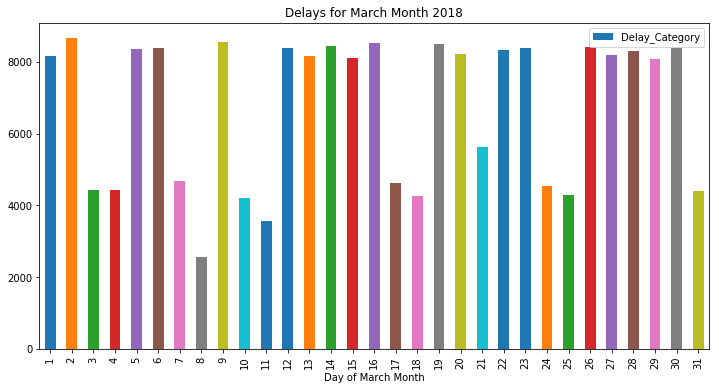

In [6]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize = (12,6))
data.groupby(data['day_month']).sum().Delay_Category.plot(kind = 'bar', title = 'Delays')

ax.set_xlabel('Day of March Month')
ax.set_title('Delays for March Month 2018')

plt.legend()
plt.show()

Above barchart tells us the information about delays each day for the month of March 2018 where mid March and end March had the most number of delays

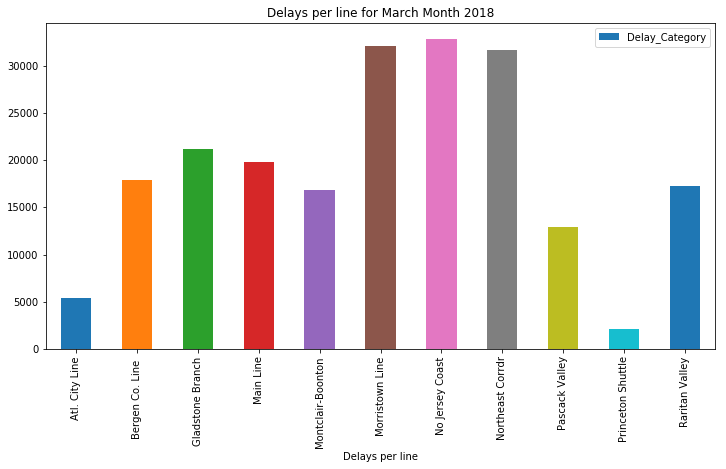

In [9]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize = (12,6))
data.groupby(data['line']).sum().Delay_Category.plot(kind = 'bar', title = 'Delays')

ax.set_xlabel('Delays per line')
ax.set_title('Delays per line for March Month 2018')

plt.legend()
plt.show()

Above barchart shows number of delays per line for March 2018 where North Jersey Coast has the most number of delays

<Figure size 1440x1440 with 0 Axes>

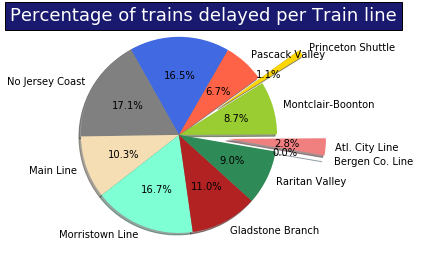

In [141]:
colors = ['royalblue', 'grey', 'wheat', 'aquamarine', 'firebrick', 'seagreen', 'lightskyblue',
          'lightcoral', 'yellowgreen', 'gold', 'tomato']
fig = plt.figure(1, figsize=(20,20))
labels = 'Northeast Corrdr', 'No Jersey Coast', 'Main Line','Morristown Line', 'Gladstone Branch', 'Raritan Valley','Bergen Co. Line ', 'Atl. City Line', 'Montclair-Boonton','Princeton Shuttle', 'Pascack Valley'
sizes = [data1, data2, data3,data4,data5,data6,data7,data8,data9,data10,data11]
explode = (0, 0, 0, 0,0, 0,0.5, 0.5,0, .5, 0)# only "explode" the 2nd slice (i.e. 'Hogs')
fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, colors = colors,autopct='%1.1f%%',
        shadow=True, startangle=60)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
ax1.set_title('Percentage of trains delayed per Train line',bbox={'facecolor':'midnightblue', 'pad':5},
              color='w', fontsize=18)

plt.show()

The above barchart explains North Jersey coast had the highest percentage of delays

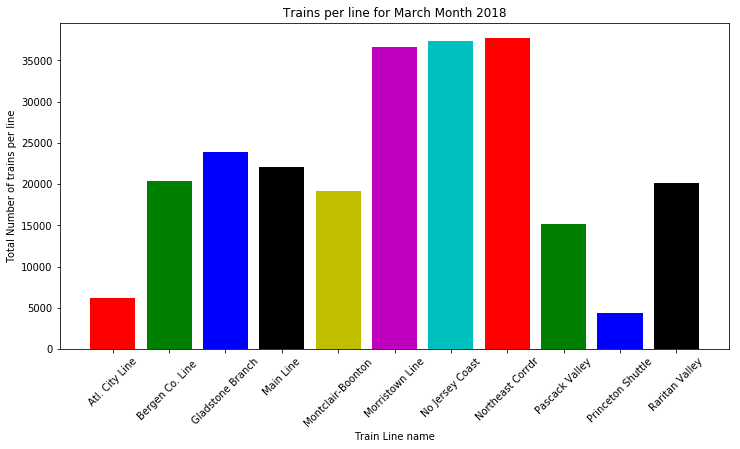

In [20]:
total_train_per_line = data['line'].groupby(data['line']).count()

fig, ax1 = plt.subplots(figsize = (12,6))

x = total_train_per_line.index.values
my_colors = 'rgbkymc'
ax1.set_xticks(np.arange(len(x)))
ax1.set_xticklabels(x, rotation = 45)
ax1.bar(np.arange(len(x)),total_train_per_line.values,color=my_colors, align='center')
ax1.set_title('Trains per line for March Month 2018')
ax1.set_xlabel('Train Line name')
ax1.set_ylabel('Total Number of trains per line')

plt.show()

The above barchart shows Northeast corridor has the most number of trains running in March 2018

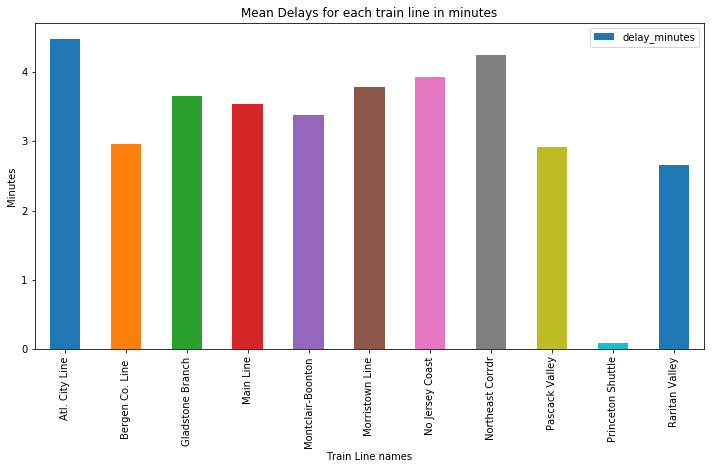

In [13]:
fig, ax = plt.subplots(figsize = (12,6))
data.groupby(data['line']).mean().delay_minutes.plot(kind = 'bar', title = 'Delays')

ax.set_xlabel('Train Line names')
ax.set_ylabel('Minutes')
ax.set_title('Mean Delays for each train line in minutes')
plt.legend()
plt.show()

Above barchart shows the mean delays for each line where Altantic city line has the highest mean delays

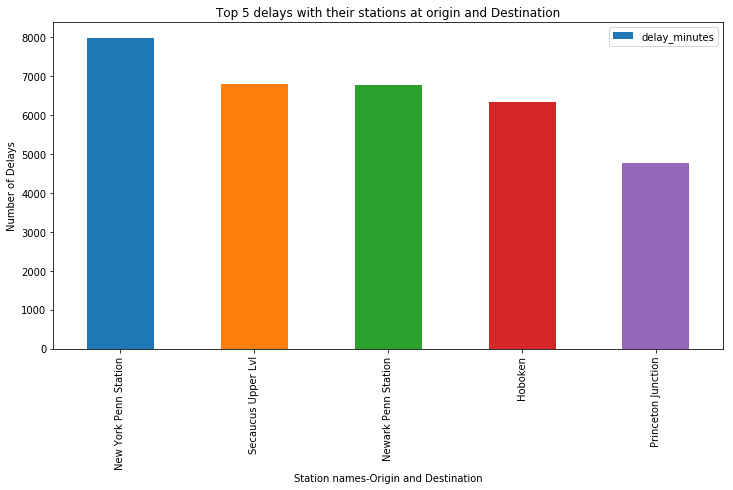

In [26]:
fig, ax = plt.subplots(figsize = (12,6))
data.groupby(data['from']).count().delay_minutes.sort_values(ascending=False).head().plot(kind = 'bar', title = 'Delays')

ax.set_xlabel('Station names-Origin and Destination')
ax.set_ylabel('Number of Delays')
ax.set_title('Top 5 delays with their stations at origin and Destination')
plt.legend()
plt.show()

Above barchart shows that New York Pennstation has the highest number of delays

# Getting X and Y variables for the model

In [6]:
#X=data.drop(['Price','Date','Address','Propertycount'],axis=1)
X=pd.get_dummies(data.drop(['scheduled_time', 'actual_time', 'delay_minutes'], 1))
Y=data['Delay_Category']
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
#X = StandardScaler().fit_transform(X)
sm = SMOTE(random_state=2)
X_sampled,y_sampled = sm.fit_sample(X,Y)
X_train_sample,X_test_sample,y_train_sample,y_test_sample = train_test_split(X_sampled,y_sampled,test_size=.20)

Above, we have got X and Y variables.Also,we did resampling of the data to balance the categorical output variable Y.We will now PCA for dimension reduction to get most of the variance in least variables as we can.Here PCA is not making much of sense but still just for reducing the dimensions, we will use PCA

# Predicting Flights Delays using models

# Dimension Reduction PCA

In [7]:
X_pca = PCA(n_components=5)
X_pca.fit(X_train_sample)
X_train_pca = X_pca.transform(X_train_sample)
X_test_pca = X_pca.transform(X_test_sample)
print(
    'The percentage of total variance in the dataset explained by each',
    'component from Sklearn PCA.\n',
    X_pca.explained_variance_ratio_
)

The percentage of total variance in the dataset explained by each component from Sklearn PCA.
 [5.98205903e-01 4.01793677e-01 2.88508306e-07 1.12429230e-07
 1.46583117e-09]


We have selected 5 components which are explaning most of the variance in the dataset.We will use all the classification models -Naive Bayes,KNN,Decision Tree,Random Forest, Linear Regression, Ridge Regression, Lasso Regression, SVC,GBR and fit the model with the data and check the accuracy of the model.First we will use gridsearch cv to get the best parameters and then the below techniques for each model and compare them-

Cross Validation

Classification_report

AUC

Confusion Matrix




# 1.Naive Bayes

In [15]:
from sklearn.naive_bayes import BernoulliNB
bnb = BernoulliNB() 
#Fitting the model with the train data
bnb = bnb.fit(X_train_pca, y_train_sample)
y_pred_bnb = bnb.predict(X_train_pca)


Accuracy: 0.9446848401880841


Since we have fitted the model with the data and we dont have any parameters to tune using gridsearch cv so we are only using Cross Validation
Classification_report,AUC,Confusion Matrix accuracy of the model

### Cross Validation

In [21]:
print("Training data accuracy for Naive Bayes: ",cross_val_score(bnb, X_train_pca, y_train_sample, cv=10))
print("Testing data accuracy Naive Bayes: ",cross_val_score(bnb, X_test_pca, y_test_sample, cv=10))

Training data accuracy for Naive Bayes:  [0.94476684 0.94551082 0.94580841 0.94473543 0.9425927  0.94396167
 0.94419975 0.94616232 0.94520996 0.94390048]
Testing data accuracy Naive Bayes:  [0.94417331 0.94572075 0.94667302 0.94703012 0.94453041 0.94381621
 0.94345238 0.94511905 0.9452381  0.94238095]


### AUC(Area Under the Curve)

In [22]:
from sklearn.metrics import roc_auc_score
print ("AUC Score for BNB :" ,roc_auc_score(y_train_sample, y_pred_bnb))

AUC Score for BNB : 0.9446707058518109


### Confusion Matrix

In [23]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score 
print(confusion_matrix(y_train_sample, y_pred_bnb))
print('Accuracy Score for BNB :',accuracy_score(y_train_sample, y_pred_bnb))

[[155079  12818]
 [  5769 162354]]
Accuracy Score for BNB : 0.9446848401880841


### Classification Report

In [24]:

print("Classification Report for BNB:",classification_report(y_train_sample, y_pred_bnb))

Classification Report for BNB:              precision    recall  f1-score   support

          0       0.96      0.92      0.94    167897
          1       0.93      0.97      0.95    168123

avg / total       0.95      0.94      0.94    336020



As we notice above, Cross validation,AUC, Confusion Matrix,Classification report are having pretty good scores.Naive Bayer is doing good job to predict the delay of trains

# 2.KNN Classification 

In [ ]:
knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(X_train_pca, y_train_sample)
y_pred_knn = knn_model.predict(X_train_pca)

### Gridsearchcv  to get the best parameters

In [25]:

params = {'n_neighbors':[5],
          'leaf_size':[1,2,3,5]
                  }
#Making models with hyper parameters sets
grid_class_knn = model_selection.GridSearchCV(knn_model, param_grid=params)
#Learning
grid_class_knn.fit(X_train_pca,y_train_sample)
#The best hyper parameters set

results = grid_class_knn.cv_results_
print(results.get('params'))
print(results.get('mean_test_score'))
print(results.get('mean_train_score'))
print("Best Hyper Parameters:\n",grid_class_knn.best_params_)
print(grid_class_knn.best_score_)
final_model = grid_class_knn.best_estimator_
print(final_model)

[{'leaf_size': 1, 'n_neighbors': 5}, {'leaf_size': 2, 'n_neighbors': 5}, {'leaf_size': 3, 'n_neighbors': 5}, {'leaf_size': 5, 'n_neighbors': 5}]
[0.99599726 0.99599726 0.99599726 0.99599726]
[0.99734837 0.99734837 0.99734837 0.99734837]
Best Hyper Parameters:
 {'leaf_size': 1, 'n_neighbors': 5}
0.9959972620677341
KNeighborsClassifier(algorithm='auto', leaf_size=1, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')


C:\Users\ankush\anacondanew\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


### Cross Validation

In [26]:
print("Training data accuracy for knn: ",cross_val_score(grid_class_knn, X_train_pca, y_train_sample, cv=10))
print("Testing data accuracy for knn: ",cross_val_score(grid_class_knn, X_test_pca, y_test_sample, cv=10))

Training data accuracy for Naive Bayes:  [0.9969348  0.99717287 0.99711335 0.99687519 0.99672639 0.99705375
 0.99705375 0.99636916 0.99705366 0.99651796]
Testing data accuracy Naive Bayes:  [0.98690632 0.98714439 0.98559695 0.98762052 0.98714439 0.98607309
 0.99047619 0.98916667 0.99       0.98630952]


### AUC

In [27]:
from sklearn.metrics import roc_auc_score
print ("AUC Score for KNN :" ,roc_auc_score(y_train_sample, y_pred_knn))

AUC Score for BNB : 0.9446707058518109


### Confusion Matrix

In [28]:
print(confusion_matrix(y_train_sample, y_pred_knn))
print('Accuracy Score for KNN :',accuracy_score(y_train_sample, y_pred_knn))

[[155079  12818]
 [  5769 162354]]
Accuracy Score for BNB : 0.9446848401880841


### Classification Report

In [29]:
print("Classification Report for knn:",classification_report(y_train_sample, y_pred_knn))

Classification Report for BNB:              precision    recall  f1-score   support

          0       0.96      0.92      0.94    167897
          1       0.93      0.97      0.95    168123

avg / total       0.95      0.94      0.94    336020



As we notice above, Cross validation,AUC, Confusion Matrix,Classification report are having pretty good scores.KNN is doing good job to predict the delay of trains.Results are very similar to Naive Bayes

# 3.Random Forest

In [8]:
rfc = ensemble.RandomForestClassifier(max_depth=10,n_estimators= 100)
rfc.fit(X_train_pca, y_train_sample)
y_pred_rfc = rfc.predict(X_train_pca)



### Gridsearchcv to get the best parameters


In [9]:
dt_grid={'max_depth':[3,4,5],'max_features': [5]}

grid_class_rfc=model_selection.GridSearchCV(rfc,dt_grid,cv=6)
grid_class_rfc.fit(X_train_pca, y_train_sample)
results = grid_class_rfc.cv_results_
print(results.get('params'))
print(results.get('mean_test_score'))
print(results.get('mean_train_score'))
print("Best Hyper Parameters:\n",grid_class_rfc.best_params_)
print(grid_class_rfc.best_score_)
final_model = grid_class_rfc.best_estimator_
print(final_model)

[{'max_depth': 3, 'max_features': 5}, {'max_depth': 4, 'max_features': 5}, {'max_depth': 5, 'max_features': 5}]
[0.97555503 0.97989703 0.98313791]
[0.97562228 0.98000476 0.98322838]
Best Hyper Parameters:
 {'max_depth': 5, 'max_features': 5}
0.9831379084578299
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features=5, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)


C:\Users\ankush\anacondanew\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


### Cross Validaton

In [ ]:
print("Training data accuracy for Random Forest: ",cross_val_score(grid_class_rfc, X_train_pca, y_train_sample, cv=10))
print("Testing data accuracy for Random Forest: ",cross_val_score(grid_class_rfc, X_test_pca, y_test_sample, cv=10))

### AUC

In [10]:
from sklearn.metrics import roc_auc_score
print ("AUC Score for Random Forest :" ,roc_auc_score(y_train_sample, y_pred_rfc))

AUC Score for Random Forest : 0.9957566277482844


### Confusion Matrix

In [13]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score 
print(confusion_matrix(y_train_sample, y_pred_rfc))
print('Accuracy Score for Random Forest :',accuracy_score(y_train_sample, y_pred_rfc))

[[168030     97]
 [  1328 166565]]
Accuracy Score for Random Forest : 0.9957591810011309


### Classification Report

In [15]:
from sklearn.metrics import classification_report
print("Classification Report for Random Forest:",classification_report(y_train_sample, y_pred_rfc))

Classification Report for Random Forest:              precision    recall  f1-score   support

          0       0.99      1.00      1.00    168127
          1       1.00      0.99      1.00    167893

avg / total       1.00      1.00      1.00    336020



Cross validation,AUC, Confusion Matrix,Classification report have very high scores for Random Forest compared to Naive Bayes and KNN.F1 score and precision are very good.

# 4.Decision Tree

We will fit the model with PCA formatted data and then gridsearch cv to get the best parameters

In [16]:
decision_tree = tree.DecisionTreeClassifier(max_depth=10)
decision_tree.fit(X_train_pca, y_train_sample)
y_pred_dt = decision_tree.predict(X_train_pca)

### GridSearchcv to get the best parameters

In [17]:

dt_grid={'max_depth':[50],'max_features': [5]}
grid_class_dt=model_selection.GridSearchCV(decision_tree,dt_grid,cv=6)
grid_class_dt.fit(X_train_pca, y_train_sample)
results = grid_class_dt.cv_results_
print(results.get('params'))
print(results.get('mean_test_score'))
print(results.get('mean_train_score'))
print("Best Hyper Parameters:\n",grid_class_dt.best_params_)
print(grid_class_dt.best_score_)
final_model = grid_class_dt.best_estimator_
print(final_model)

[{'max_depth': 50, 'max_features': 5}]
[0.9972829]
[1.]
Best Hyper Parameters:
 {'max_depth': 50, 'max_features': 5}
0.9972828998273913
DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=50,
            max_features=5, max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')


C:\Users\ankush\anacondanew\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


### Cross Validaton

In [19]:
print("Training data accuracy for Decision Tree: ",cross_val_score(grid_class_dt, X_train_pca, y_train_sample, cv=10))
print("Testing data accuracy for Decision Tree: ",cross_val_score(grid_class_dt, X_test_pca, y_test_sample, cv=10))

Training data accuracy for Decision Tree:  [0.99726215 0.99797637 0.99705383 0.99696447 0.99752991 0.99755967
 0.99764895 0.99752984 0.9975596  0.9975596 ]
Testing data accuracy for Decision Tree:  [0.99440543 0.99392929 0.99416736 0.99440543 0.99416736 0.99583383
 0.9947619  0.99535714 0.99464286 0.995     ]


### AUC

In [20]:
from sklearn.metrics import roc_auc_score
print ("AUC Score for Decision Tree :" ,roc_auc_score(y_train_sample, y_pred_dt))

AUC Score for Decision Tree : 0.9946050924418225


### Confusion Matrix

In [22]:
print(confusion_matrix(y_train_sample, y_pred_dt))
print('Accuracy Score for Decision Tree :',accuracy_score(y_train_sample, y_pred_dt))

[[167074   1053]
 [   760 167133]]
Accuracy Score for Decision Tree : 0.9946044878281055


### Classification Report

In [23]:
print("Classification Report for Decision Tree:",classification_report(y_train_sample, y_pred_dt))

Classification Report for Decision Tree:              precision    recall  f1-score   support

          0       1.00      0.99      0.99    168127
          1       0.99      1.00      0.99    167893

avg / total       0.99      0.99      0.99    336020



Cross validation,AUC, Confusion Matrix,Classification report have very high scores for Decision Tree  compared to Naive Bayes and KNN.F1 score and precision are very good.

# 5.SVC

We will fit the model with PCA formatted data and then gridsearch cv to get the best parameters

In [ ]:
from sklearn.svm import SVC
svm=SVC()
svm.fit(X_train_pca, y_train_sample)
y_pred_svm = svm.predict(X_train_pca)


### GridSearchcv to get the best parameters


In [ ]:
param_grid = {'C':[1,10,100,1000],'gamma':[1,0.1,0.001,0.0001], 'kernel':['linear','rbf']}
grid_class_svm=model_selection.GridSearchCV(SVC(),param_grid,refit = True)
grid_class_svm.fit(X_train_pca, y_train)
results = grid_class_svm.cv_results_
print(results.get('params'))
print(results.get('mean_test_score'))
print(results.get('mean_train_score'))
print("Best Hyper Parameters:\n",grid_class_svm.best_params_)
print(grid_class_svm.best_score_)
final_model = grid_class_svm.best_estimator_
print(final_model)

### Cross Validaton


In [ ]:
print("Training data accuracy for Random Forest: ",cross_val_score(grid_class_rfc, X_train_pca, y_train_sample, cv=10))
print("Testing data accuracy for Random Forest: ",cross_val_score(grid_class_rfc, X_test_pca, y_test_sample, cv=10))

### AUC

In [ ]:
from sklearn.metrics import roc_auc_score
print ("AUC Score for Random Forest :" ,roc_auc_score(y_train_sample, y_pred_rfc))

### Confusion Matrix

In [ ]:
print(confusion_matrix(y_train_sample, y_pred_bnb))
print('Accuracy Score for Random Forest :',accuracy_score(y_train_sample, y_pred_rfc))

### Classification Report

In [ ]:
print("Classification Report for Random Forest:",classification_report(y_train_sample, y_pred_rfc))

# 6.Linear Regression

We will fit the model with PCA formatted data and then gridsearch cv to get the best parameters

In [8]:
lr = LogisticRegression(C=1e9)
lr.fit(X_train_pca, y_train_sample)
y_pred_lr = lr.predict(X_train_pca)

### GridSearchcv to get the best parameters


In [9]:
grid={"C":np.logspace(-3,3,7), "penalty":["l1","l2"]}# l1 lasso l2 ridge
logreg_cv=model_selection.GridSearchCV(lr,grid,cv=10)
logreg_cv.fit(X_train_pca,y_train_sample)
results = logreg_cv.cv_results_
print(results.get('params'))
print(results.get('mean_test_score'))
print(results.get('mean_train_score'))
print("Best Hyper Parameters:\n",logreg_cv.best_params_)
print(logreg_cv.best_score_)
final_model = logreg_cv.best_estimator_
print(final_model)

[{'C': 0.001, 'penalty': 'l1'}, {'C': 0.001, 'penalty': 'l2'}, {'C': 0.01, 'penalty': 'l1'}, {'C': 0.01, 'penalty': 'l2'}, {'C': 0.1, 'penalty': 'l1'}, {'C': 0.1, 'penalty': 'l2'}, {'C': 1.0, 'penalty': 'l1'}, {'C': 1.0, 'penalty': 'l2'}, {'C': 10.0, 'penalty': 'l1'}, {'C': 10.0, 'penalty': 'l2'}, {'C': 100.0, 'penalty': 'l1'}, {'C': 100.0, 'penalty': 'l2'}, {'C': 1000.0, 'penalty': 'l1'}, {'C': 1000.0, 'penalty': 'l2'}]
[0.96623118 0.96428189 0.96783525 0.9655586  0.96798107 0.96660318
 0.96799893 0.96662996 0.96799893 0.96662996 0.9680019  0.96662996
 0.96798702 0.96662996]
[0.96627284 0.96428453 0.967866   0.96540384 0.9679943  0.96651026
 0.96800521 0.96653241 0.96800686 0.96653771 0.96800984 0.96653804
 0.96800124 0.96653804]
Best Hyper Parameters:
 {'C': 100.0, 'penalty': 'l1'}
0.9680019046485329
LogisticRegression(C=100.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_st

C:\Users\ankush\anacondanew\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


### Cross Validaton

In [10]:
print("Training data accuracy for Linear Regression: ",cross_val_score(logreg_cv, X_train_pca, y_train_sample, cv=10))
print("Testing data accuracy for Linear Regression: ",cross_val_score(logreg_cv, X_test_pca, y_test_sample, cv=10))

Training data accuracy for Random Forest:  [0.96860399 0.96652085 0.9692587  0.96833522 0.9682757  0.96699601
 0.96821618 0.96711407 0.96729264 0.97145918]
Testing data accuracy for Random Forest:  [0.96428997 0.964409   0.964409   0.96488513 0.96667063 0.96559933
 0.96880952 0.96440476 0.96702381 0.97166667]


### AUC

In [11]:
from sklearn.metrics import roc_auc_score
print ("AUC Score for Linear Regression :" ,roc_auc_score(y_train_sample, y_pred_lr))

AUC Score for Linear Regression : 0.9647210124446269


### Confusion Matrix

In [13]:

print(confusion_matrix(y_train_sample, y_pred_lr))
print('Accuracy Score for Linear Regression :',accuracy_score(y_train_sample, y_pred_lr))

[[163510   4743]
 [  7108 160659]]
Accuracy Score for Linear Regression : 0.9647312659960716


### Classification Report

In [15]:
from sklearn.metrics import classification_report
print("Classification Report for Linear Regression:",classification_report(y_train_sample, y_pred_lr))

Classification Report for Linear Regression:              precision    recall  f1-score   support

          0       0.96      0.97      0.97    168253
          1       0.97      0.96      0.96    167767

avg / total       0.96      0.96      0.96    336020



Cross validation,AUC, Confusion Matrix,Classification report have very high scores.F1 score and precision are very good.

# GradientBoostingClassifier

We will fit the model with PCA formatted data and then gridsearch cv to get the best parameters

In [17]:
params = {'n_estimators': 500,
          'max_depth': 7,
          'loss': 'deviance'}
clf = ensemble.GradientBoostingClassifier(**params)
clf.fit(X_train_pca, y_train_sample)
y_pred_gbr = clf.predict(X_train_pca)

### GridSearchcv to get the best parameters

In [ ]:
params ={
    "loss":["deviance"],
    "max_depth":[3,5,8],
    "n_estimators":[1000]
    }
gb = model_selection.GridSearchCV(clf, params, cv=10)
gb.fit(X_train_pca, y_train_sample)
results = gb.cv_results_
print(results.get('params'))
print(results.get('mean_test_score'))
print(results.get('mean_train_score'))
print("Best Hyper Parameters:\n",gb.best_params_)
print(gb.best_score_)
final_model = gb.best_estimator_
print(final_model)


### Cross Validaton

In [ ]:
print("Training data accuracy for GBR: ",cross_val_score(gb, X_train_pca, y_train_sample, cv=10))
print("Testing data accuracy for GBR: ",cross_val_score(gb, X_test_pca, y_test_sample, cv=10))

### AUC

In [ ]:
from sklearn.metrics import roc_auc_score
print ("AUC Score for GBR :" ,roc_auc_score(y_train_sample, y_pred_gbr))

### Confusion Matrix

In [ ]:
print(confusion_matrix(y_train_sample, y_pred_gbr))
print('Accuracy Score for GBR :',accuracy_score(y_train_sample, y_pred_gbr))

### Classification Report

In [ ]:
print("Classification Report for GBR:",classification_report(y_train_sample, y_pred_gbr))

Now, we will use SKB for dimension reduction and use the same techniques as above to get the accuracy of each model

# SELECTKBEST(SKB)

In [7]:
skb = SelectKBest(f_classif,k=5)
skb.fit(X_train_sample, y_train_sample)
X_train_skb = skb.transform(X_train_sample)
X_test_skb = skb.transform(X_test_sample)


C:\Users\ankush\anacondanew\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [   3 1699] are constant.
  UserWarning)
C:\Users\ankush\anacondanew\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
C:\Users\ankush\anacondanew\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


# 1.Naive Bayes

In [10]:
from sklearn.naive_bayes import BernoulliNB
bnb = BernoulliNB() 
#Fitting the model with the train data
bnb = bnb.fit(X_train_skb, y_train_sample)
y_pred_bnb = bnb.predict(X_train_skb)

### Cross Validation

In [11]:
print("Training data accuracy for Naive Bayes: ",cross_val_score(bnb, X_train_skb, y_train_sample, cv=10))
print("Testing data accuracy Naive Bayes: ",cross_val_score(bnb, X_test_skb, y_test_sample, cv=10))

Training data accuracy for Naive Bayes:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Testing data accuracy Naive Bayes:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


### AUC

In [37]:
from sklearn.metrics import roc_auc_score
print ("AUC Score for BNB :" ,roc_auc_score(y_train_sample, y_pred_bnb))

AUC Score for BNB : 1.0


### Confusion Matrix


In [16]:
print(confusion_matrix(y_train_sample, y_pred_bnb))
print('Accuracy Score for BNB :',accuracy_score(y_train_sample, y_pred_bnb))

[[167809      0]
 [     0 168211]]
Accuracy Score for BNB : 1.0


### Classification Report

In [17]:
print("Classification Report for BNB:",classification_report(y_train_sample, y_pred_bnb))

Classification Report for BNB:              precision    recall  f1-score   support

          0       1.00      1.00      1.00    167809
          1       1.00      1.00      1.00    168211

avg / total       1.00      1.00      1.00    336020



In [ ]:
Cross validation,AUC, Confusion Matrix,Classification report seem to have much better results than PCA

# 2.KNN Classification


In [8]:
knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(X_train_skb, y_train_sample)
y_pred_knn = knn_model.predict(X_train_skb)

### Gridsearchcv to get the best parameters


In [19]:
params = {'n_neighbors':[5],
          'leaf_size':[1,2,3,5]
                  }
#Making models with hyper parameters sets
grid_class_knn = model_selection.GridSearchCV(knn_model, param_grid=params)
#Learning
grid_class_knn.fit(X_train_pca,y_train_sample)
#The best hyper parameters set

results = grid_class_knn.cv_results_
print(results.get('params'))
print(results.get('mean_test_score'))
print(results.get('mean_train_score'))
print("Best Hyper Parameters:\n",grid_class_knn.best_params_)
print(grid_class_knn.best_score_)
final_model = grid_class_knn.best_estimator_
print(final_model)

[{'leaf_size': 1, 'n_neighbors': 5}, {'leaf_size': 2, 'n_neighbors': 5}, {'leaf_size': 3, 'n_neighbors': 5}, {'leaf_size': 5, 'n_neighbors': 5}]
[0.95001786 0.95001786 0.95001786 0.95001786]
[0.97008214 0.97008214 0.97008214 0.97008214]
Best Hyper Parameters:
 {'leaf_size': 1, 'n_neighbors': 5}
0.9500178560799952
KNeighborsClassifier(algorithm='auto', leaf_size=1, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')


C:\Users\ankush\anacondanew\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


### Cross Validaton

In [ ]:
print("Training data accuracy for KNN: ",cross_val_score(grid_class_knn, X_train_skb, y_train_sample, cv=10))
print("Testing data accuracy for KNN: ",cross_val_score(grid_class_knn, X_test_skb, y_test_sample, cv=10))

### AUC

In [9]:
from sklearn.metrics import roc_auc_score
print ("AUC Score for KNN :" ,roc_auc_score(y_train_sample, y_pred_knn))

AUC Score for KNN : 1.0


### Confusion Matrix

In [10]:
print("Classification Report for KNN:",classification_report(y_train_sample, y_pred_knn))

Classification Report for KNN:              precision    recall  f1-score   support

          0       1.00      1.00      1.00    167926
          1       1.00      1.00      1.00    168094

avg / total       1.00      1.00      1.00    336020



### Classification Report

In [11]:
print("Classification Report for KNN:",classification_report(y_train_sample, y_pred_knn))

Classification Report for KNN:              precision    recall  f1-score   support

          0       1.00      1.00      1.00    167926
          1       1.00      1.00      1.00    168094

avg / total       1.00      1.00      1.00    336020



Cross validation,AUC, Confusion Matrix,Classification report seem to have much better results than PCA.The results seem perfect.It looks like the model got fitted perfectly with the data

# 3.Random Forest


In [10]:
rfc = ensemble.RandomForestClassifier(max_depth=10,n_estimators= 100)
rfc.fit(X_train_skb, y_train_sample)
y_pred_rfc = rfc.predict(X_train_skb)


### GridSearchcv to get the best parameters

In [11]:
dt_grid={'max_depth':[3,4,5],'max_features': [5]}

grid_class_rfc=model_selection.GridSearchCV(rfc,dt_grid,cv=6)
grid_class_rfc.fit(X_train_skb, y_train_sample)
results = grid_class_rfc.cv_results_
print(results.get('params'))
print(results.get('mean_test_score'))
print(results.get('mean_train_score'))
print("Best Hyper Parameters:\n",grid_class_rfc.best_params_)
print(grid_class_rfc.best_score_)
final_model = grid_class_rfc.best_estimator_
print(final_model)

[{'max_depth': 3, 'max_features': 5}, {'max_depth': 4, 'max_features': 5}, {'max_depth': 5, 'max_features': 5}]
[1. 1. 1.]
[1. 1. 1.]
Best Hyper Parameters:
 {'max_depth': 3, 'max_features': 5}
1.0
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=3, max_features=5, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)


C:\Users\ankush\anacondanew\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


### Cross Validaton

In [ ]:
print("Training data accuracy for Random Forest: ",cross_val_score(grid_class_rfc, X_train_skb, y_train_sample, cv=10))
print("Testing data accuracy for Random Forest: ",cross_val_score(grid_class_rfc, X_test_skb, y_test_sample, cv=10))

### AUC

In [15]:
print ("AUC Score for Random Forest :" ,roc_auc_score(y_train_sample, y_pred_rfc))

AUC Score for Random Forest : 1.0


### Confusion Matrix

In [16]:
print('Accuracy Score for Random Forest :',accuracy_score(y_train_sample, y_pred_rfc))

Accuracy Score for Random Forest : 1.0


### Classification Report

In [17]:
print("Classification Report for Random Forest:",classification_report(y_train_sample, y_pred_rfc))

Classification Report for Random Forest:              precision    recall  f1-score   support

          0       1.00      1.00      1.00    168014
          1       1.00      1.00      1.00    168006

avg / total       1.00      1.00      1.00    336020



Cross validation,AUC, Confusion Matrix,Classification report seem to have much better results than PCA.The results seem perfect.It looks like the model got fitted perfectly with the data

# 4.Decision Tree

In [19]:
decision_tree = tree.DecisionTreeClassifier(max_depth=10)
decision_tree.fit(X_train_skb, y_train_sample)
y_pred_dt = decision_tree.predict(X_train_skb)

### Gridsearchcv to get the best parameters

In [20]:
dt_grid={'max_depth':[50],'max_features': [5]}
grid_class_dt=model_selection.GridSearchCV(decision_tree,dt_grid,cv=6)
grid_class_dt.fit(X_train_skb, y_train_sample)
results = grid_class_dt.cv_results_
print(results.get('params'))
print(results.get('mean_test_score'))
print(results.get('mean_train_score'))
print("Best Hyper Parameters:\n",grid_class_dt.best_params_)
print(grid_class_dt.best_score_)
final_model = grid_class_dt.best_estimator_
print(final_model)

[{'max_depth': 50, 'max_features': 5}]
[1.]
[1.]
Best Hyper Parameters:
 {'max_depth': 50, 'max_features': 5}
1.0
DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=50,
            max_features=5, max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')


C:\Users\ankush\anacondanew\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


### Cross Validaton

In [24]:
print("Training data accuracy for Decision Tree: ",cross_val_score(grid_class_dt, X_train_skb, y_train_sample, cv=5))
print("Testing data accuracy for Decision Tree: ",cross_val_score(grid_class_dt, X_test_skb, y_test_sample, cv=5))

Training data accuracy for Decision Tree:  [1. 1. 1. 1. 1.]
Testing data accuracy for Decision Tree:  [1. 1. 1. 1. 1.]


### AUC

In [21]:
from sklearn.metrics import roc_auc_score
print ("AUC Score for Decision Tree :" ,roc_auc_score(y_train_sample, y_pred_dt))

AUC Score for Decision Tree : 1.0


### Confusion Matrix

In [22]:
print(confusion_matrix(y_train_sample, y_pred_dt))
print('Accuracy Score for Decision Tree :',accuracy_score(y_train_sample, y_pred_dt))

[[168014      0]
 [     0 168006]]
Accuracy Score for Decision Tree : 1.0


### Classification Report

In [23]:
print("Classification Report for Decision Tree:",classification_report(y_train_sample, y_pred_dt))

Classification Report for Decision Tree:              precision    recall  f1-score   support

          0       1.00      1.00      1.00    168014
          1       1.00      1.00      1.00    168006

avg / total       1.00      1.00      1.00    336020



Cross validation,AUC, Confusion Matrix,Classification report seem to have much better results than PCA.The results seem perfect.It looks like the model got fitted perfectly with the data

# 4.SVC

In [22]:
from sklearn.svm import SVC
svm=SVC()
svm.fit(X_train_skb, y_train_sample)
y_pred_svm = svm.predict(X_train_skb)

### Gridsearchcv to get the best parameters

In [ ]:
param_grid = {'C':[1,10,100,1000],'gamma':[1,0.1,0.001,0.0001], 'kernel':['linear','rbf']}
grid_class_svm=model_selection.GridSearchCV(SVC(),param_grid,refit = True)
grid_class_svm.fit(X_train_skb, y_train_sample)
results = grid_class_svm.cv_results_
print(results.get('params'))
print(results.get('mean_test_score'))
print(results.get('mean_train_score'))
print("Best Hyper Parameters:\n",grid_class_svm.best_params_)
print(grid_class_svm.best_score_)
final_model = grid_class_svm.best_estimator_
print(final_model)

### Cross Validaton

In [ ]:
print("Training data accuracy for SVC: ",cross_val_score(grid_class_svm, X_train_skb, y_train_sample, cv=5))
print("Testing data accuracy for SVC: ",cross_val_score(grid_class_svm, X_test_skb, y_test_sample, cv=5))

### AUC

In [ ]:
from sklearn.metrics import roc_auc_score
print ("AUC Score for SVC :" ,roc_auc_score(y_train_sample, y_pred_dt))

### Confusion Matrix

In [ ]:
print(confusion_matrix(y_train_sample, y_pred_dt))
print('Accuracy Score for SVC :',accuracy_score(y_train_sample, y_pred_dt))

### Classification Report

In [ ]:
print("Classification Report for SVC:",classification_report(y_train_sample, y_pred_dt))

# 6.Linear Regression

In [9]:
lr = LogisticRegression(C=1e9)
lr.fit(X_train_skb, y_train_sample)
y_pred_lr = lr.predict(X_train_skb)

### Gridsearchcv to get the best parameters

In [10]:
grid={"C":np.logspace(-3,3,7), "penalty":["l1","l2"]}# l1 lasso l2 ridge
logreg_cv=model_selection.GridSearchCV(lr,grid,cv=10)
logreg_cv.fit(X_train_skb,y_train_sample)
results = logreg_cv.cv_results_
print(results.get('params'))
print(results.get('mean_test_score'))
print(results.get('mean_train_score'))
print("Best Hyper Parameters:\n",logreg_cv.best_params_)
print(logreg_cv.best_score_)
final_model = logreg_cv.best_estimator_
print(final_model)

[{'C': 0.001, 'penalty': 'l1'}, {'C': 0.001, 'penalty': 'l2'}, {'C': 0.01, 'penalty': 'l1'}, {'C': 0.01, 'penalty': 'l2'}, {'C': 0.1, 'penalty': 'l1'}, {'C': 0.1, 'penalty': 'l2'}, {'C': 1.0, 'penalty': 'l1'}, {'C': 1.0, 'penalty': 'l2'}, {'C': 10.0, 'penalty': 'l1'}, {'C': 10.0, 'penalty': 'l2'}, {'C': 100.0, 'penalty': 'l1'}, {'C': 100.0, 'penalty': 'l2'}, {'C': 1000.0, 'penalty': 'l1'}, {'C': 1000.0, 'penalty': 'l2'}]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Best Hyper Parameters:
 {'C': 0.001, 'penalty': 'l1'}
1.0
LogisticRegression(C=0.001, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)


C:\Users\ankush\anacondanew\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


### Cross Validaton

In [13]:
print("Training data accuracy for Linear Regression: ",cross_val_score(logreg_cv, X_train_skb, y_train_sample, cv=5))
print("Testing data accuracy for Linear Regression: ",cross_val_score(logreg_cv, X_test_skb, y_test_sample, cv=5))

Training data accuracy for Linear Regression:  [1. 1. 1. 1. 1.]
Testing data accuracy for Linear Regression:  [1. 1. 1. 1. 1.]


### AUC

In [11]:
from sklearn.metrics import roc_auc_score
print ("AUC Score for Linear Regression :" ,roc_auc_score(y_train_sample, y_pred_lr))

AUC Score for Linear Regression : 1.0


### Confusion Matrix

In [12]:
print(confusion_matrix(y_train_sample, y_pred_lr))
print('Accuracy Score for Linear Regression :',accuracy_score(y_train_sample, y_pred_lr))

[[167936      0]
 [     0 168084]]
Accuracy Score for Linear Regression : 1.0


### Classification Report

In [20]:
print("Classification Report for Linear Regression:",classification_report(y_train_sample, y_pred_lr))

Classification Report for Linear Regression:              precision    recall  f1-score   support

          0       1.00      1.00      1.00    167936
          1       1.00      1.00      1.00    168084

avg / total       1.00      1.00      1.00    336020



Cross validation,AUC, Confusion Matrix,Classification report seem to have much better results than PCA.The results seem perfect.It looks like the model got fitted perfectly with the data

# 7.Gradient Boost Classifier

In [8]:
params = {'n_estimators': 500,
          'max_depth': 7,
          'loss': 'deviance'}
clf = ensemble.GradientBoostingClassifier(**params)
clf.fit(X_train_skb, y_train_sample)
y_pred_gbr = clf.predict(X_train_skb)

### Gridsearchcv to get the best parameters


In [9]:
params ={
    "loss":["deviance"],
    "max_depth":[3,5,8],
    "n_estimators":[1000]
    }
gb = model_selection.GridSearchCV(clf, params, cv=10)
gb.fit(X_train_skb, y_train_sample)
results = gb.cv_results_
print(results.get('params'))
print(results.get('mean_test_score'))
print(results.get('mean_train_score'))
print("Best Hyper Parameters:\n",gb.best_params_)
print(gb.best_score_)
final_model = gb.best_estimator_
print(final_model)

[{'loss': 'deviance', 'max_depth': 3, 'n_estimators': 1000}, {'loss': 'deviance', 'max_depth': 5, 'n_estimators': 1000}, {'loss': 'deviance', 'max_depth': 8, 'n_estimators': 1000}]
[1. 1. 1.]
[1. 1. 1.]
Best Hyper Parameters:
 {'loss': 'deviance', 'max_depth': 3, 'n_estimators': 1000}
1.0
GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=1000,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False)


C:\Users\ankush\anacondanew\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


### Cross Validaton

In [ ]:
print("Training data accuracy for GBR: ",cross_val_score(gb, X_train_skb, y_train_sample, cv=5))
print("Testing data accuracy for GBR: ",cross_val_score(gb, X_test_skb, y_test_sample, cv=5))

### AUC

In [17]:
from sklearn.metrics import roc_auc_score
print ("AUC Score for GBR :" ,roc_auc_score(y_train_sample, y_pred_gbr))

AUC Score for GBR : 1.0


### Confusion Matrix

In [18]:
print(confusion_matrix(y_train_sample, y_pred_gbr))
print('Accuracy Score for GBR :',accuracy_score(y_train_sample, y_pred_gbr))

[[167936      0]
 [     0 168084]]
Accuracy Score for GBR : 1.0


### Classification Report

In [ ]:
print("Classification Report for GBR:",classification_report(y_train_sample, y_pred_gbr))

Cross validation,AUC, Confusion Matrix,Classification report seem to have much better results than PCA.The results seem perfect.It looks like the model got fitted perfectly with the data

# Conclusion

As we notice above in the data analysis part, North Jersey Coast Line had the maximum number of delays in March2018.Also, we came to know the North Jersey Coast line had the hightest frequency of trains running in March.Altantic city line had the highest mean in delay minutes which means that its delay duration is more than the other lines.Further,most of delays got delayed either during the mid of March or end week of March.Delay factors can be maintenance,more train lines running from or to  the same train station and because of frequency of the trains.The station where delays were the highest was Newyork penn station.It is reasonable since the amount of train that run in this station is very high and it is the hub of all the trains starting  fom New York or New York as its destination.
 Now looking at the models, SelectkBest fared better than PCA for getting the model accuracy which is understandable because there was no need of PCA other than to reduce the dimensions.We did the  resampling of the data in order to balance the categories of the outcome variable which is very understandable as well.All the models produced very good accuracy results.Precision and F1 scores were very impressive which means the probability for correctly predicting the outcome are very high.There was no trace of any overfitting which means that the input variables an outcome variables were chosen in the correct way.There were no outliers in Confusion Matrix since no negative or positive outliers were seen in the results.Gridsearch provided the best parameters which enabled all the models to have very good accuracy scores.SVC and  GBR were the slowest for the runtime.They were slow to complete in both PCA and SKB which means they might not be considered for this dataset because of the excessive runtime.All of the other models fared well with the dataset.There could have been more analysis if further details have been provided in the dataset such as weather ,speed of the trains,stops of the train lines,duration from source to destination.The best results will be known if we have the realtime data to the fit the models and then we will be able to know how accurate the models will behave provided we chose outcome varable and input variables carefully.